# 1. Load dataset

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('log2.csv')
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


# 2. Basic EDA + preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [ ]:
df.shape

(65532, 12)

In [ ]:
# Missing values check
df.isnull().sum()

,0
Source Port,0
Destination Port,0
NAT Source Port,0
NAT Destination Port,0
Action,0
Bytes,0
Bytes Sent,0
Bytes Received,0
Packets,0
Elapsed Time (sec),0


In [ ]:
# Duplicated values check
df.duplicated().sum()

np.int64(8362)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

np.int64(0)

# 3. Data Visulizations

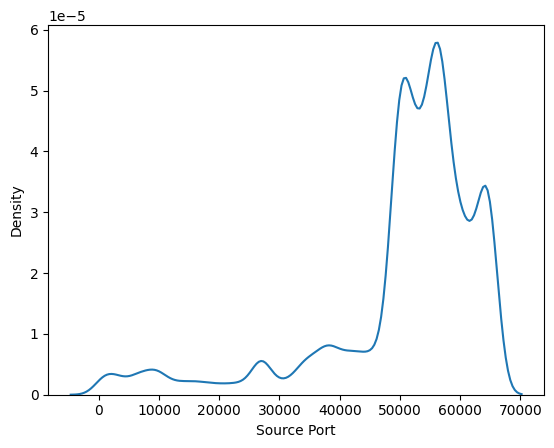

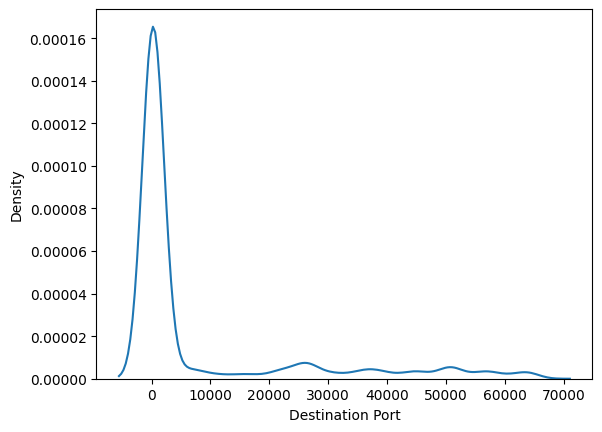

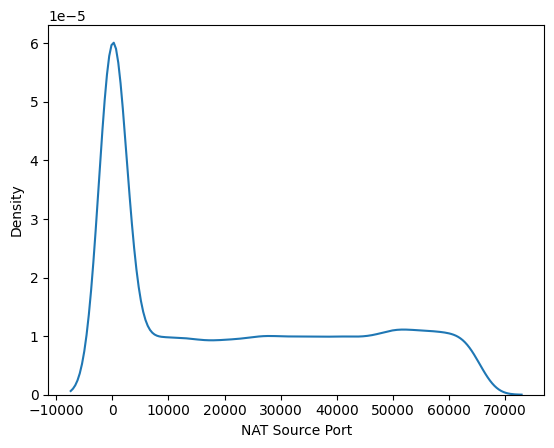

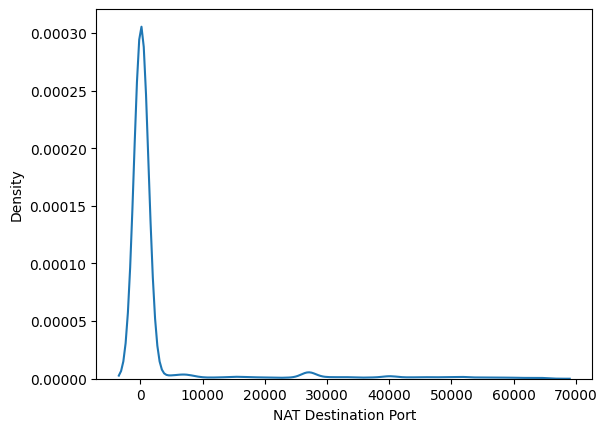

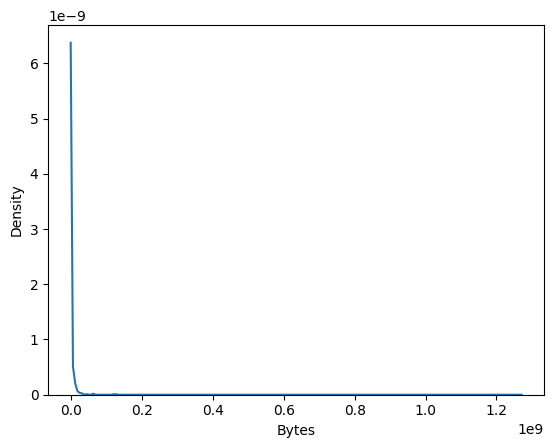

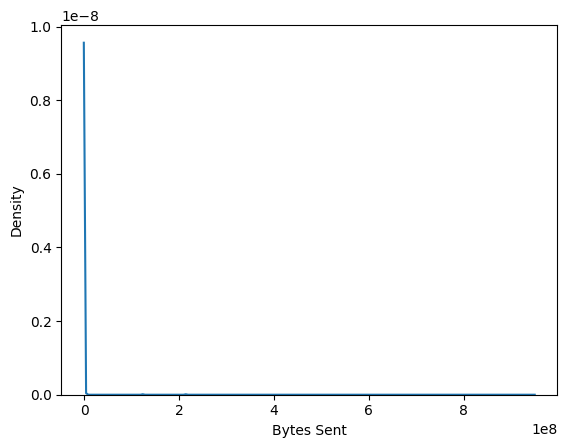

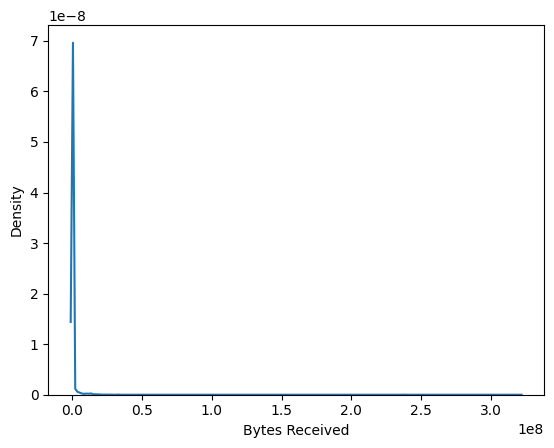

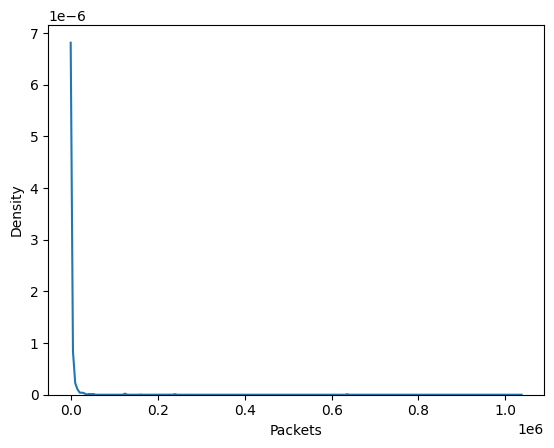

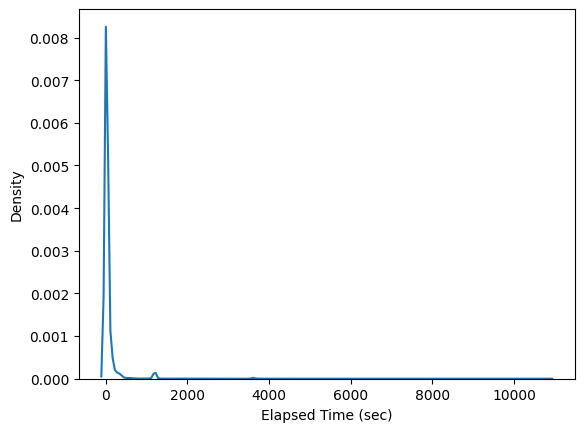

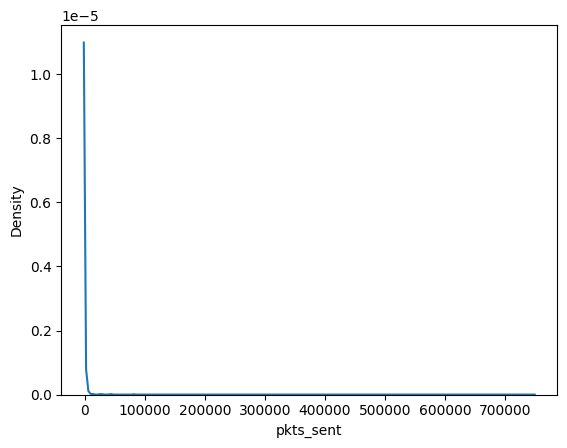

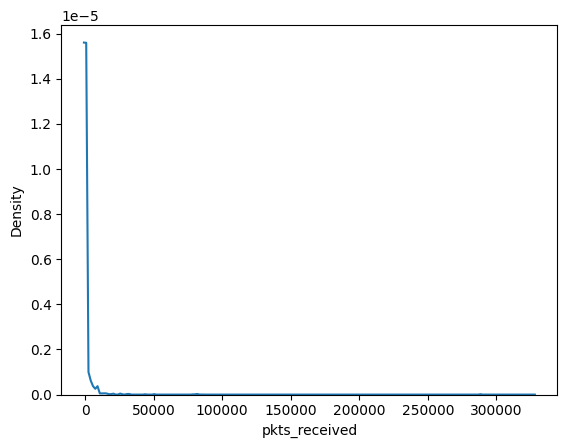

In [ ]:
# Kde plot
import seaborn as sns
import matplotlib.pyplot as plt
for col in df.select_dtypes(include=['int64']):
  sns.kdeplot(df[col])
  plt.show()

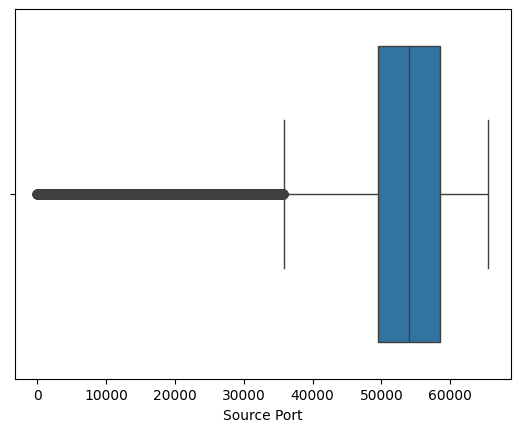

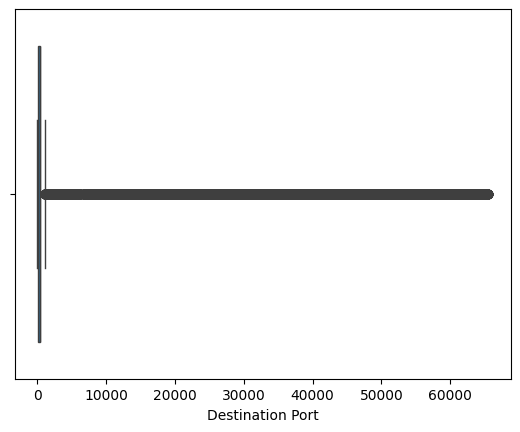

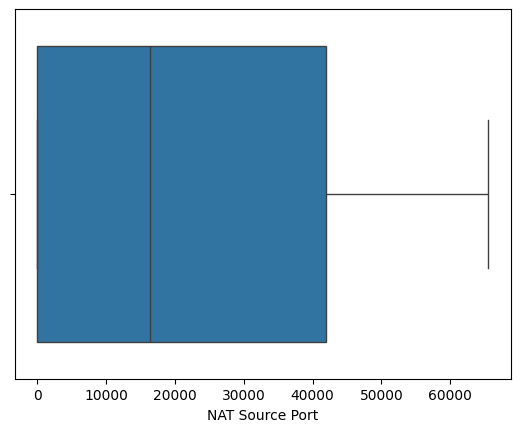

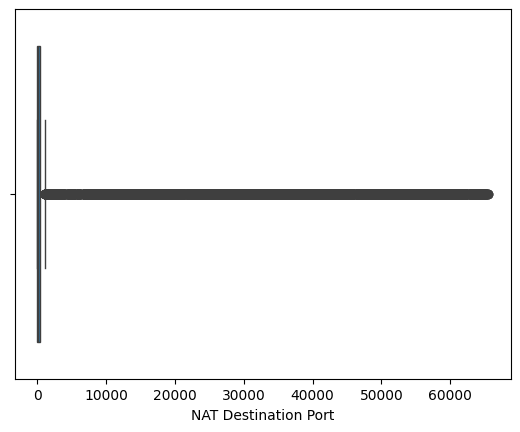

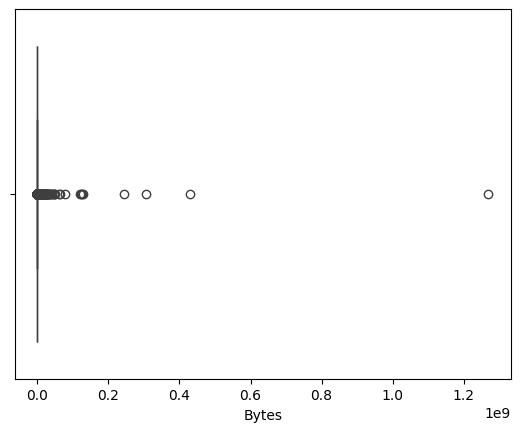

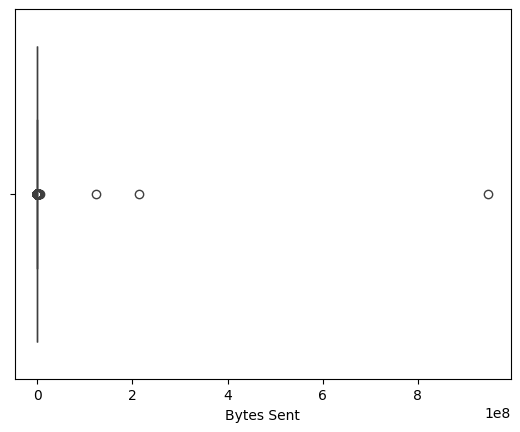

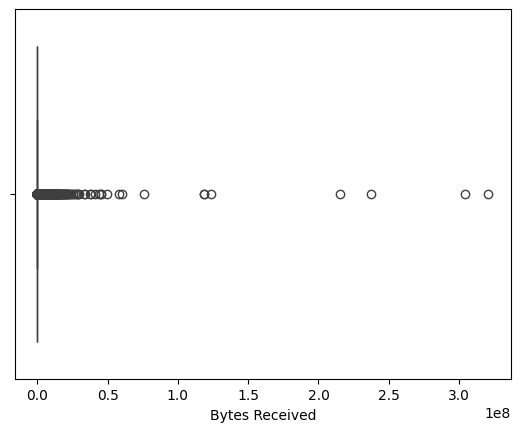

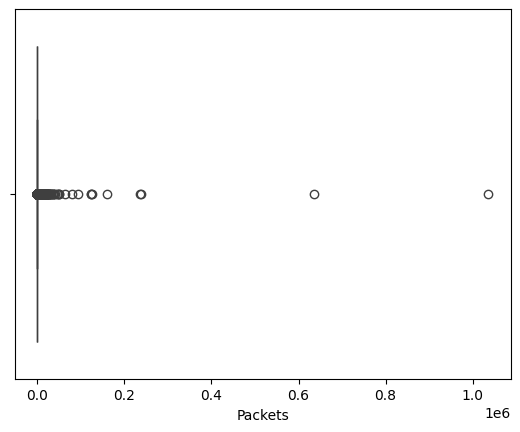

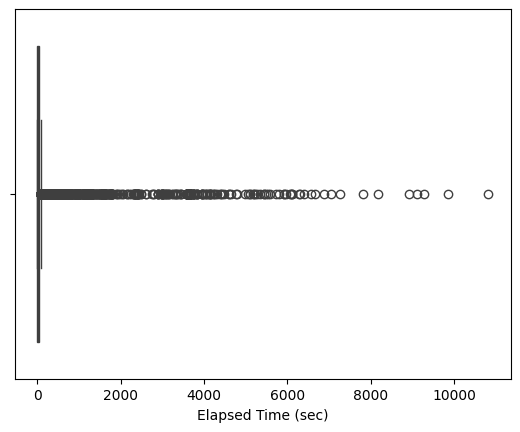

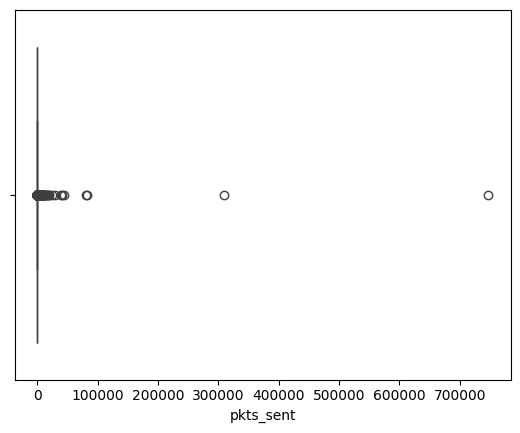

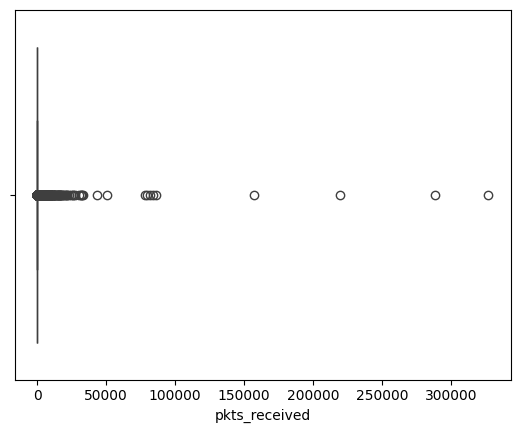

In [ ]:
# Boxplot
import seaborn as sns
import matplotlib.pyplot as plt
for col in df.select_dtypes(include=['int64']):
  sns.boxplot(x=df[col])
  plt.show()

# 4. Further data preprocessing

In [ ]:
# Splitting data into input and output columns
X = df.drop('Action', axis=1)
Y = df['Action']

In [ ]:
# Scaling the values
from sklearn.preprocessing import StandardScaler
cols = df.select_dtypes(include=['int64']).columns
sc = StandardScaler()
X_scaled = sc.fit_transform(X[cols])
X_scaled

array([[ 0.48193304, -0.48441511,  1.46954047, ..., -0.13988911,
        -0.01342915, -0.02916823],
       [ 0.41248339, -0.28239247,  1.54500862, ..., -0.18019713,
        -0.01081756, -0.02580722],
       [-3.14479395,  2.55973179,  0.95819976, ...,  3.48473162,
        -0.01342915, -0.02916823],
       ...,
       [ 0.03108666, -0.48278003, -0.38676812, ...,  0.00583987,
         0.27210441,  1.52067983],
       [ 0.31255946, -0.46067624, -0.9957974 , ..., -0.23290761,
        -0.01342915, -0.02958836],
       [ 0.31248742, -0.46067624, -0.9957974 , ..., -0.23290761,
        -0.01342915, -0.02958836]])

In [ ]:
# Label encoding output column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_le = le.fit_transform(Y)
Y_le

array([0, 0, 0, ..., 0, 2, 2])

# 5. Model selection and hyperparameter tunning

In [ ]:
# Defining model params
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators':[50, 100, 150]
        }
    },
    'logistic_regression':{
        'model':LogisticRegression(solver='liblinear'),
        'params': {
            'C': [1,5,10]
        }
    }
}

In [ ]:
# Finding optimal model and its best hyperparameters
from sklearn.model_selection import GridSearchCV
scores = []
for model_name, params in model_params.items():
  clf = GridSearchCV(params['model'], params['params'], cv=5, return_train_score=False)
  clf.fit(X, Y)
  scores.append({
      'model': model_name,
      'best_score': clf.best_score_,
      'best_params': clf.best_params_
  })

pd.DataFrame(scores, columns=['model','best_score','best_params'])

,model,best_score,best_params
0,random_forest,0.990572,{'n_estimators': 50}
1,logistic_regression,0.980777,{'C': 1}


# 6. Train Test split and applying algorithm

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_le, test_size=0.2, random_state=42)

In [ ]:
# Applying random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)

0.9978135385691796

Text(50.722222222222214, 0.5, 'Truth')

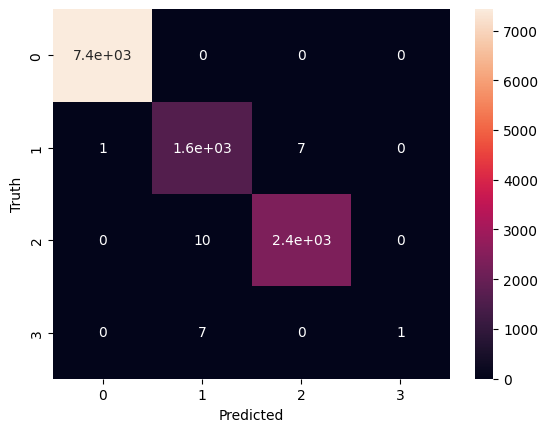

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = rf.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7430
           1       0.99      1.00      0.99      1615
           2       1.00      1.00      1.00      2381
           3       1.00      0.12      0.22         8

    accuracy                           1.00     11434
   macro avg       1.00      0.78      0.80     11434
weighted avg       1.00      1.00      1.00     11434



# 7. Evaluating other ML Algorithms

In [ ]:
# SVM
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, Y_train)
svc.score(X_test, Y_test)

0.987231065244009

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)
lr.score(X_test, Y_test)

0.987318523701242

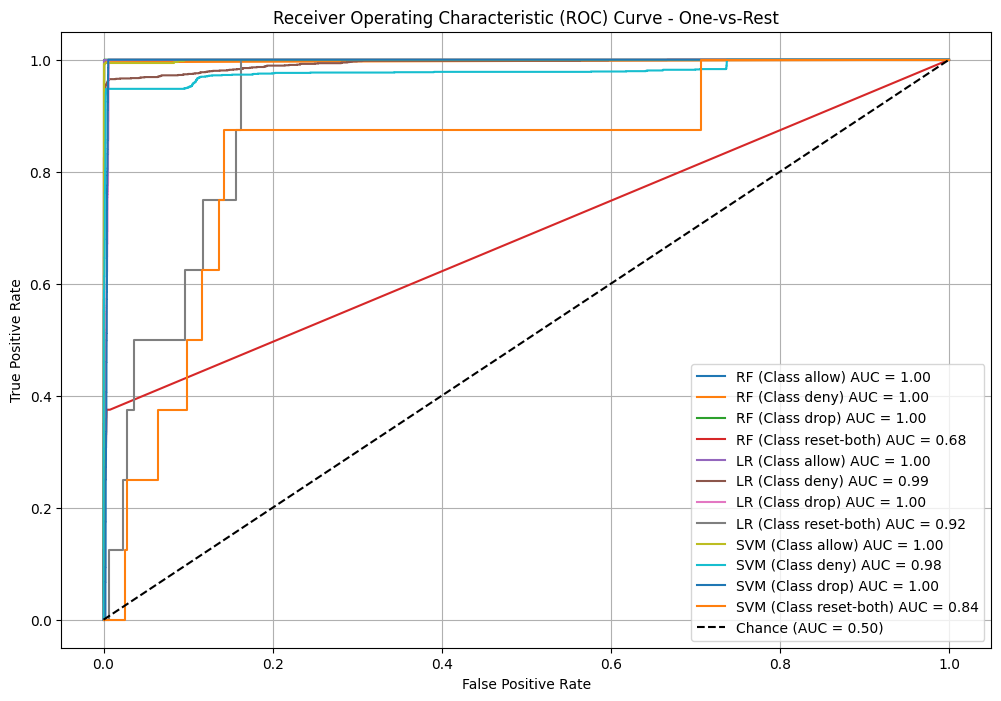

In [ ]:
# Showing roc-auc curve
from sklearn.metrics import roc_curve, auc

unique_classes = np.unique(Y_test)

plt.figure(figsize=(12, 8))

y_score_rf_proba = rf.predict_proba(X_test)
for i, class_id in enumerate(unique_classes):
    y_true_binary = (Y_test == class_id).astype(int)
    fpr_rf, tpr_rf, _ = roc_curve(y_true_binary, y_score_rf_proba[:, i])
    auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f"RF (Class {le.inverse_transform([class_id])[0]}) AUC = {auc_rf:.2f}")

y_score_log_proba = lr.predict_proba(X_test)
for i, class_id in enumerate(unique_classes):
    y_true_binary = (Y_test == class_id).astype(int)
    fpr_log, tpr_log, _ = roc_curve(y_true_binary, y_score_log_proba[:, i])
    auc_log = auc(fpr_log, tpr_log)
    plt.plot(fpr_log, tpr_log, label=f"LR (Class {le.inverse_transform([class_id])[0]}) AUC = {auc_log:.2f}")

y_score_svm_decision = svc.decision_function(X_test)
for i, class_id in enumerate(unique_classes):
    y_true_binary = (Y_test == class_id).astype(int)
    fpr_svm, tpr_svm, _ = roc_curve(y_true_binary, y_score_svm_decision[:, i])
    auc_svm = auc(fpr_svm, tpr_svm)
    plt.plot(fpr_svm, tpr_svm, label=f"SVM (Class {le.inverse_transform([class_id])[0]}) AUC = {auc_svm:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()